<a href="https://colab.research.google.com/github/BaRRdAk/rcnn/blob/main/gdal_raster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3

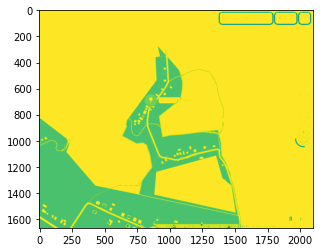

In [101]:
from osgeo import osr, gdal, ogr
import matplotlib.pyplot as plt
import numpy as np


ds = gdal.Open("scr_1.tiff")
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[rows, cols] = arr.shape
arr_min = arr.min()
arr_max = arr.max()
arr_mean = int(arr.mean())
arr_out = np.where((arr < arr_mean), 10000, arr)

geoTiffDriver = gdal.GetDriverByName("GTiff")

# gdal.GDT_UInt16
tods = geoTiffDriver.Create("test_2.tif", cols, rows, 1, gdal.GDT_Byte)

srs = osr.SpatialReference()
#srs.ImportFromEPSG(4326)
srs.ImportFromProj4("+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs")
tods.SetProjection( srs.ExportToWkt() )

# GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
# GT(1) w-e pixel resolution / pixel width.
# GT(2) row rotation (typically zero).
# GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
# GT(4) column rotation (typically zero).
# GT(5) n-s pixel resolution / pixel height (negative value for a north-up image)

bottom_left = [4699325.9903368,6465458.8001235]
top_right = [4743331.4897824,6507106.8620988]
x_pixel_res = rows/(top_right[0] - bottom_left[0])
y_pixel_res = cols/(bottom_left[1] - top_right[1])

tods.SetGeoTransform([4743331.4897824, x_pixel_res, 0, 6507106.8620988, 0, y_pixel_res])


tods.GetRasterBand(1).WriteArray(arr_out)
#tods.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
tods.FlushCache() ##saves to disk!!
tods = None
band=None
ds=None

dataset_2 = gdal.Open("test_2.tif")

# show result
band = dataset_2.GetRasterBand(1)
arr = band.ReadAsArray()

im = plt.imshow(arr)


# vectorize
dst_layername = "POLYGONIZED_STUFF"
shapeDriver = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = shapeDriver.CreateDataSource(dst_layername + ".shp")

dst_layer = dst_ds.CreateLayer(dst_layername, srs=None)
gdal.Polygonize(band, None, dst_layer, -1, [], callback=None)

# simplify
feat = dst_layer.GetFeature(0)
geom = feat.geometry()
simple = geom.Simplify(0.2)

target_ds = geoTiffDriver.Create("rasterize.tif", 500, 500, gdal.GDT_Byte)

gdal.RasterizeLayer(target_ds, [3,2,1], dst_layer, burn_values=[200,220,240])

